In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sns
import re
import numpy as np
from typing import List, Dict
from scipy.interpolate import interpn
from matplotlib import cm
from matplotlib.colors import Normalize

In [2]:
def import_pca(dir_path, sample, chrom_sizes, pc="pc") -> pd.DataFrame:
    dfs = []
    for chrom in chrom_sizes["chrom"]:
        path = os.path.join(dir_path, f"{chrom}.{pc}.bedGraph")
        if not os.path.exists(path):
            continue
        dfs.append(pd.read_table(path, names=["chrom", "start", "end", sample]))

    return pd.concat(dfs)


def quantile_normalize(df: pd.DataFrame, cols: List[str]):
    dfs = []

    for _, dff in df.groupby("chrom"):
        # compute rank
        dic = {}
        for col in cols:
            dic.update({col: sorted(dff[col])})
            sorted_df = pd.DataFrame(dic)
            rank = sorted_df.mean(axis=1).tolist()
        # sort
        for col in cols:
            t = np.searchsorted(np.sort(dff[col]), dff[col])
            dff[col] = [rank[i] for i in t]
        dfs.append(dff)
    return pd.concat(dfs)


def get_compartment_ranks() -> Dict:
    compartment_labels = tuple(
        ["B", "B3", "B2", "B1", "B0", "A0", "A1", "A2", "A3", "A"]
    )
    return {k: v for v, k in enumerate(compartment_labels)}

In [3]:
# ! tar -xf ../data/compartment_analysis/10000/MCF10A_WT_T1_C1_10000.dchic.tar.zst -C /tmp/ --wildcards "*.pc.bedGraph"

In [4]:
subcomps = pd.read_table(
    "../data/output/compartment_analysis/10000/MCF10A_WT_T1_C1_10000.subcompartments.bedGraph.gz"
).rename(columns={"chr": "chrom"})
chrom_sizes = pd.read_table(
    "../data/input/hg38/hg38.filtered.chrom.sizes", names=["chrom", "size"]
)
subcomps

,chrom,start,end,padj,MCF10A_WT.state,MCF10A_WT.score,MCF10A_T1.state,MCF10A_T1.score,MCF10A_C1.state,MCF10A_C1.score,state.mode
0,chr1,40000,50000,1.000000e+00,A0,0.339,A1,1.022,A0,0.339,A0
1,chr1,50000,60000,1.000000e+00,A0,0.339,A1,1.022,A0,0.339,A0
2,chr1,60000,70000,1.000000e+00,A0,0.339,A1,1.022,A0,0.339,A0
3,chr1,70000,80000,6.096919e-01,A0,0.339,A1,1.022,A0,0.339,A0
4,chr1,80000,90000,2.676917e-01,A0,0.339,A1,1.022,A0,0.339,A0
...,...,...,...,...,...,...,...,...,...,...,...
272559,chrX,155660000,155670000,5.054290e-09,B1,-0.946,A3,1.984,B0,-0.251,NaN
272560,chrX,155670000,155680000,3.128434e-04,B1,-0.946,A3,1.984,B0,-0.251,NaN
272561,chrX,155680000,155690000,1.256388e-05,B1,-0.946,A3,1.984,B0,-0.251,NaN
272562,chrX,155690000,155700000,5.408553e-03,B1,-0.946,A3,1.984,B0,-0.251,NaN


In [5]:
dfs = []

for dir in sorted(glob.glob("/tmp/MCF10A_WT_T1_C1_10000/*_pca/")):
    sample_name = os.path.basename(dir.rstrip("/")).removesuffix("_pca")
    # intra_pca/*_mat/"
    f = list(glob.glob(os.path.join(dir, "intra_pca", "*_mat")))
    assert len(f) == 1
    dfs.append(import_pca(f[0], sample_name, chrom_sizes))

df = None
for dff in dfs:
    if df is None:
        df = dff
        continue
    df = df.merge(dff, on=["chrom", "start", "end"])

df = subcomps.merge(df, on=["chrom", "start", "end"])
df

,chrom,start,end,padj,MCF10A_WT.state,MCF10A_WT.score,MCF10A_T1.state,MCF10A_T1.score,MCF10A_C1.state,MCF10A_C1.score,state.mode,hg38_001_MCF10A_WT_REP1,hg38_002_MCF10A_WT_REP2,hg38_003_MCF10A_T1_REP1,hg38_004_MCF10A_T1_REP2,hg38_005_MCF10A_C1_REP1,hg38_006_MCF10A_C1_REP2
0,chr1,40000,50000,1.000000e+00,A0,0.339,A1,1.022,A0,0.339,A0,22.169559,10.750060,16.995788,13.379283,13.041097,9.394673
1,chr1,50000,60000,1.000000e+00,A0,0.339,A1,1.022,A0,0.339,A0,12.742776,8.561351,15.416735,21.563119,8.617732,17.003801
2,chr1,60000,70000,1.000000e+00,A0,0.339,A1,1.022,A0,0.339,A0,14.619984,15.716796,28.506393,17.900659,13.265006,15.456405
3,chr1,70000,80000,6.096919e-01,A0,0.339,A1,1.022,A0,0.339,A0,15.623983,6.077123,20.089641,18.181772,-0.301363,4.990546
4,chr1,80000,90000,2.676917e-01,A0,0.339,A1,1.022,A0,0.339,A0,2.435605,4.888925,17.866467,27.167819,15.821876,20.372334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272559,chrX,155660000,155670000,5.054290e-09,B1,-0.946,A3,1.984,B0,-0.251,NaN,-19.360841,-25.090678,18.426517,17.742438,-8.700233,-8.007959
272560,chrX,155670000,155680000,3.128434e-04,B1,-0.946,A3,1.984,B0,-0.251,NaN,-17.532054,-21.288374,13.956533,16.388080,-5.708262,-7.006657
272561,chrX,155680000,155690000,1.256388e-05,B1,-0.946,A3,1.984,B0,-0.251,NaN,-18.821064,-31.450607,13.958913,14.519886,-8.227961,-11.306263
272562,chrX,155690000,155700000,5.408553e-03,B1,-0.946,A3,1.984,B0,-0.251,NaN,-18.159731,-26.030501,14.931578,9.996818,-6.929187,-8.676359


In [6]:
data = {
    "chrom": [],
    "start": [],
    "end": [],
    "label": [],
    "rep1": [],
    "rep2": [],
    "pca1": [],
    "pca2": [],
    "pca_rel_err": [],
    "subcomp1": [],
    "subcomp2": [],
    "pca_delta": [],
    "subcomp_delta": [],
}
cols = [col for col in df.columns if col.startswith("hg38_")]

# df = quantile_normalize(df, cols)

for col1 in cols:
    for col2 in cols:
        if col1 == col2:
            continue

        mask = df["padj"] < 0.01

        pca_delta = df[col2] - df[col1]
        pca_delta = pca_delta[mask]
        pca_rel_err = ((df[col2] - df[col1]) / df[col1]).abs()
        pca_rel_err = pca_rel_err[mask]

        label = (
            re.sub(r"^hg38_\d+_MCF10A_", "", col1)
            + "_vs_"
            + re.sub(r"^hg38_\d+_MCF10A_", "", col2)
        )
        cond1 = (
            re.sub(r"^hg38_\d+_MCF10A_", "", col1)
            .removesuffix("_REP1")
            .removesuffix("_REP2")
        )
        cond2 = (
            re.sub(r"^hg38_\d+_MCF10A_", "", col2)
            .removesuffix("_REP1")
            .removesuffix("_REP2")
        )

        subcomp_delta = df[f"MCF10A_{cond2}.state"].map(get_compartment_ranks()) - df[
            f"MCF10A_{cond1}.state"
        ].map(get_compartment_ranks())
        subcomp_delta = subcomp_delta[mask]

        data["chrom"].extend(df.loc[mask, "chrom"].tolist())
        data["start"].extend(df.loc[mask, "start"].tolist())
        data["end"].extend(df.loc[mask, "end"].tolist())

        data["label"].extend([label] * len(pca_delta))
        data["rep1"].extend([col1] * len(pca_delta))
        data["rep2"].extend([col2] * len(pca_delta))

        data["pca1"].extend(df.loc[mask, col1].tolist())
        data["pca2"].extend(df.loc[mask, col2].tolist())
        data["pca_rel_err"].extend(pca_rel_err.tolist())
        data["subcomp1"].extend(df.loc[mask, f"MCF10A_{cond1}.state"].tolist())
        data["subcomp2"].extend(df.loc[mask, f"MCF10A_{cond2}.state"].tolist())

        data["pca_delta"].extend(pca_delta)
        data["subcomp_delta"].extend(subcomp_delta)


df1 = pd.DataFrame(data)
df1

,chrom,start,end,label,rep1,rep2,pca1,pca2,pca_rel_err,subcomp1,subcomp2,pca_delta,subcomp_delta
0,chr1,630000,640000,WT_REP1_vs_WT_REP2,hg38_001_MCF10A_WT_REP1,hg38_002_MCF10A_WT_REP2,-4.340611,-1.711988,0.605588,A0,A0,2.628622,0
1,chr1,2130000,2140000,WT_REP1_vs_WT_REP2,hg38_001_MCF10A_WT_REP1,hg38_002_MCF10A_WT_REP2,61.573856,67.905962,0.102838,A2,A2,6.332106,0
2,chr1,2210000,2220000,WT_REP1_vs_WT_REP2,hg38_001_MCF10A_WT_REP1,hg38_002_MCF10A_WT_REP2,42.885516,55.726145,0.299416,A1,A1,12.840629,0
3,chr1,2220000,2230000,WT_REP1_vs_WT_REP2,hg38_001_MCF10A_WT_REP1,hg38_002_MCF10A_WT_REP2,42.608761,46.030310,0.080302,A1,A1,3.421549,0
4,chr1,2250000,2260000,WT_REP1_vs_WT_REP2,hg38_001_MCF10A_WT_REP1,hg38_002_MCF10A_WT_REP2,41.400557,47.096997,0.137593,A1,A1,5.696441,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
884845,chrX,155660000,155670000,C1_REP2_vs_C1_REP1,hg38_006_MCF10A_C1_REP2,hg38_005_MCF10A_C1_REP1,-8.007959,-8.700233,0.086448,B0,B0,-0.692273,0
884846,chrX,155670000,155680000,C1_REP2_vs_C1_REP1,hg38_006_MCF10A_C1_REP2,hg38_005_MCF10A_C1_REP1,-7.006657,-5.708262,0.185309,B0,B0,1.298395,0
884847,chrX,155680000,155690000,C1_REP2_vs_C1_REP1,hg38_006_MCF10A_C1_REP2,hg38_005_MCF10A_C1_REP1,-11.306263,-8.227961,0.272265,B0,B0,3.078302,0
884848,chrX,155690000,155700000,C1_REP2_vs_C1_REP1,hg38_006_MCF10A_C1_REP2,hg38_005_MCF10A_C1_REP1,-8.676359,-6.929187,0.201372,B0,B0,1.747172,0


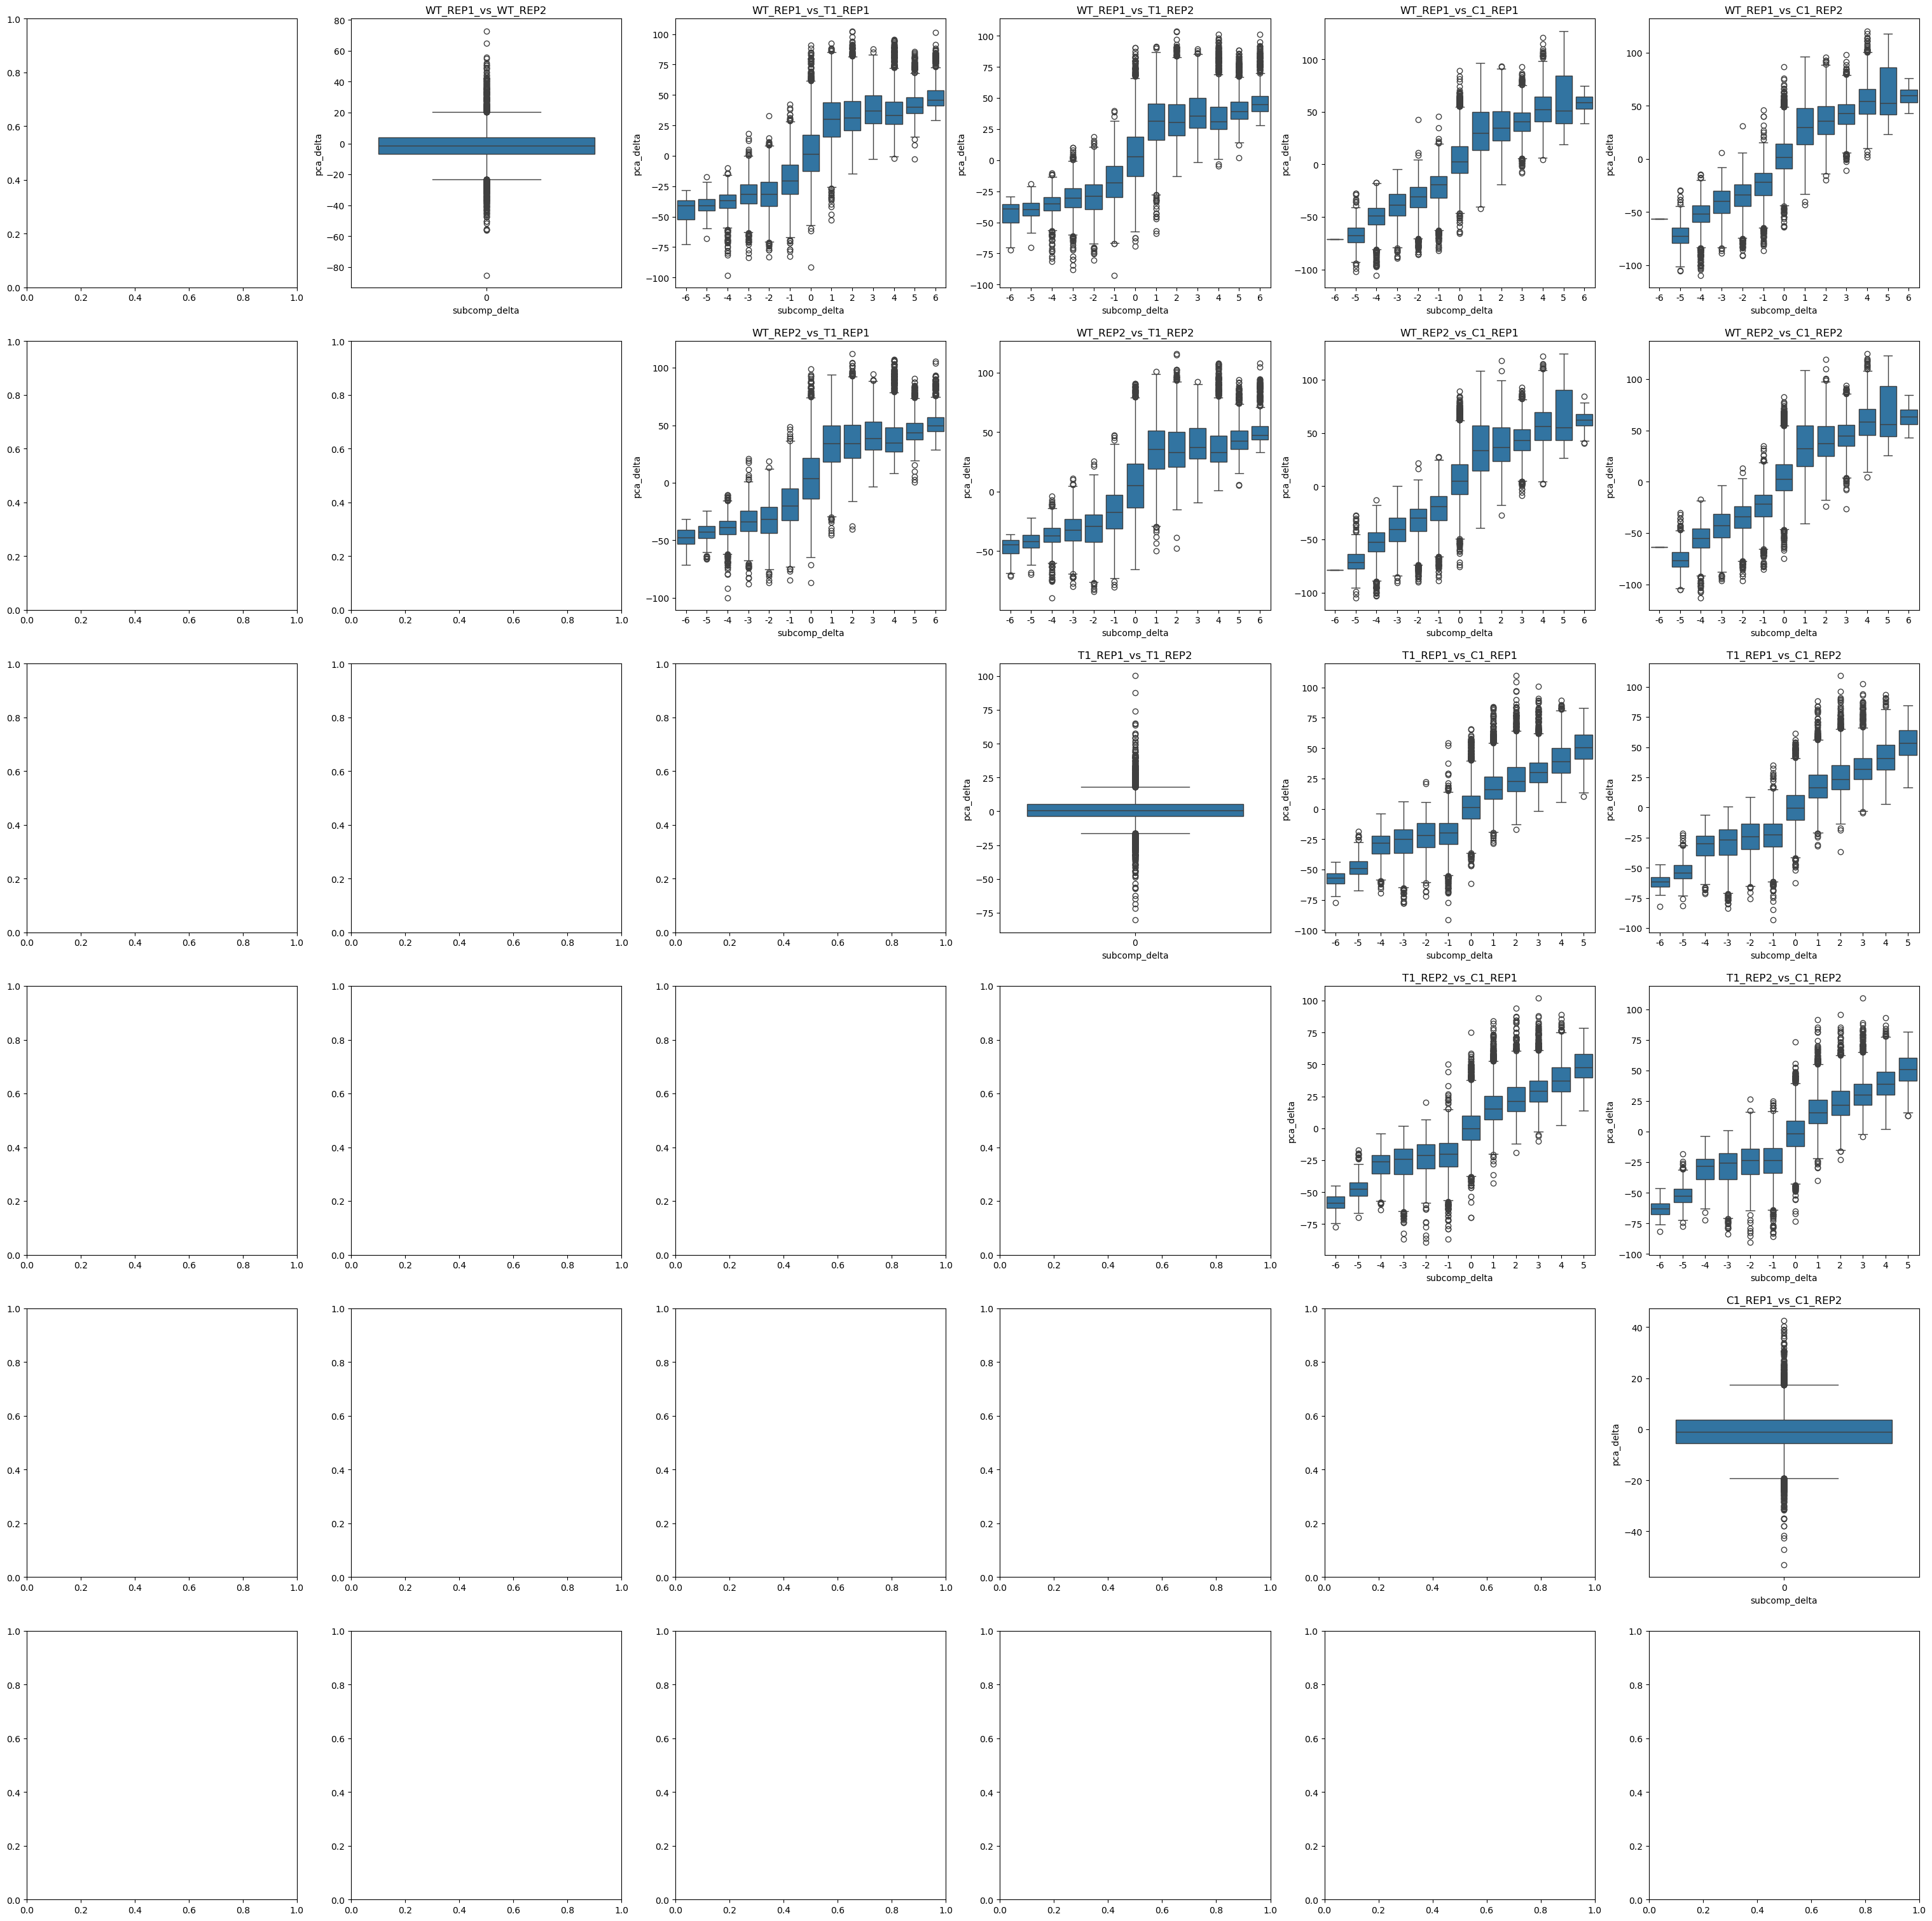

In [7]:
fig, axs = plt.subplots(
    len(cols), len(cols), figsize=(len(cols) * 6.4, len(cols) * 6.4)
)
for i1, col1 in enumerate(cols):
    for i2, col2 in enumerate(cols):
        if i1 >= i2:
            continue
        ax = axs[i1][i2]
        dff = df1[(df1["rep1"] == col1) & (df1["rep2"] == col2)]
        sns.boxplot(dff, x="subcomp_delta", y="pca_delta", ax=ax)

        rep1 = re.sub(r"^hg38_\d+_MCF10A_", "", col1)
        rep2 = re.sub(r"^hg38_\d+_MCF10A_", "", col2)
        ax.set(title=f"{rep1}_vs_{rep2}")

fig.savefig("/tmp/diff_boxplot.png", dpi=150)

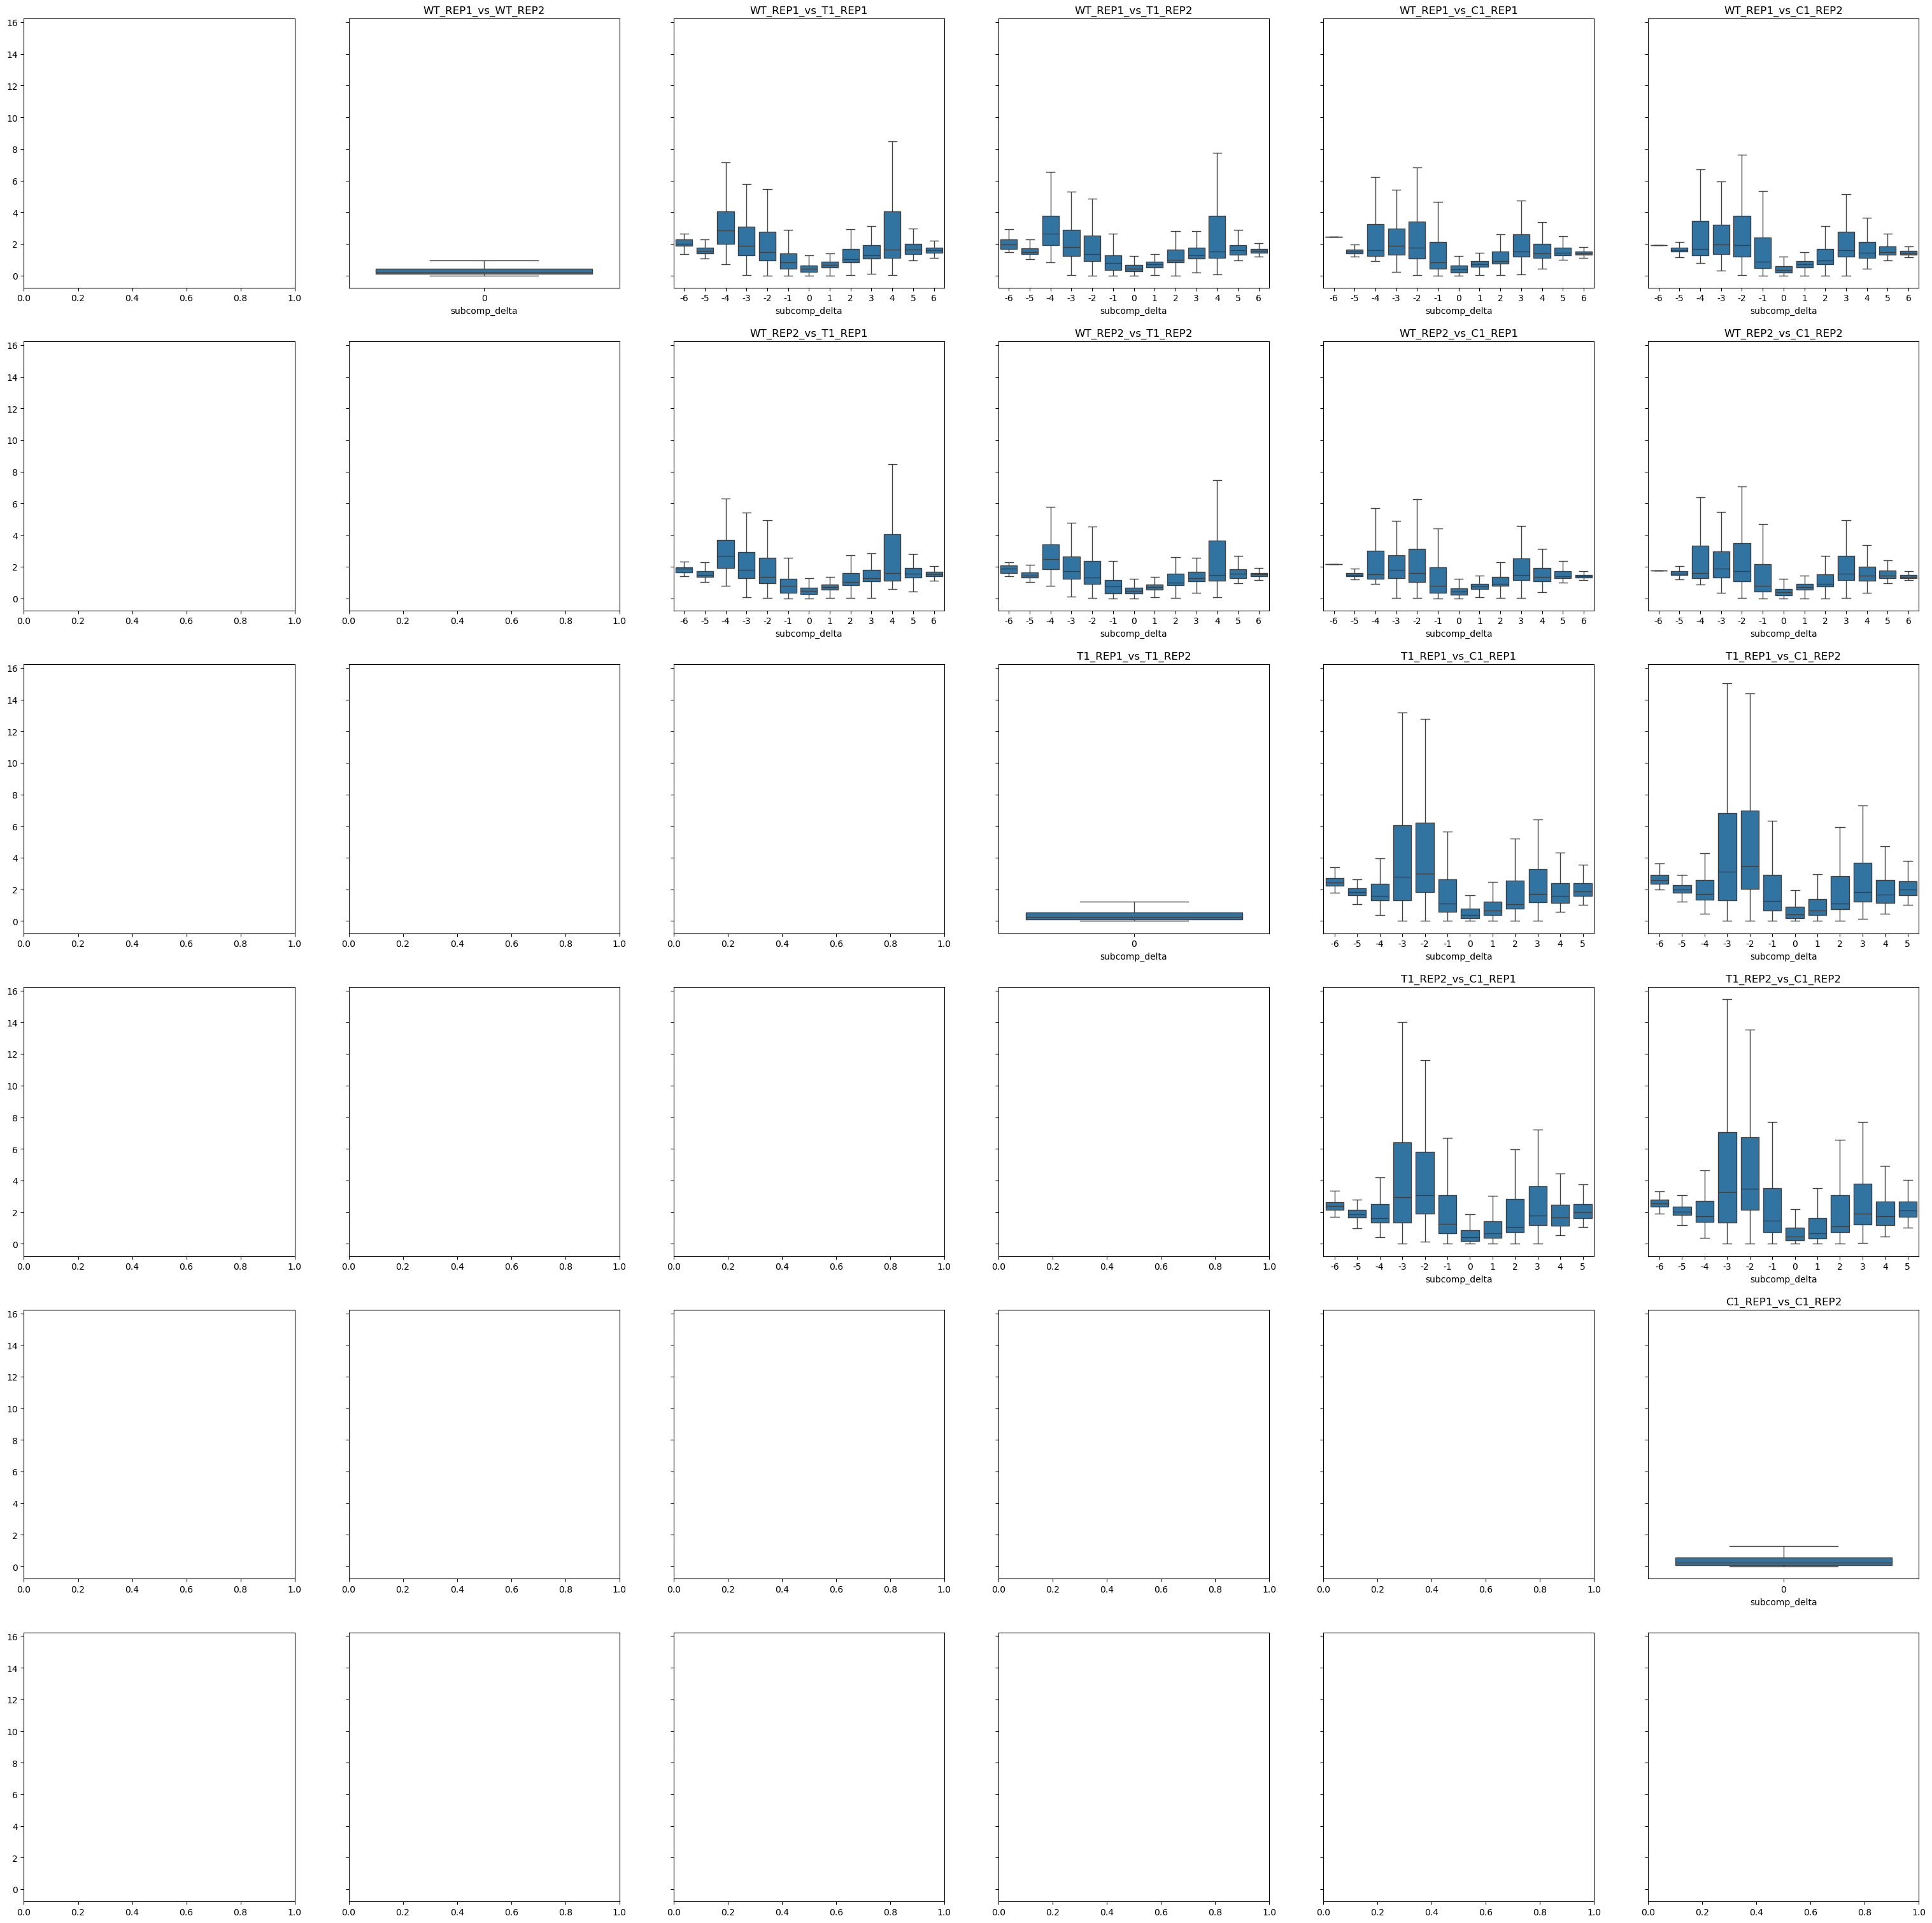

In [8]:
fig, axs = plt.subplots(
    len(cols), len(cols), figsize=(len(cols) * 6.4, len(cols) * 6.4), sharey=True
)
for i1, col1 in enumerate(cols):
    for i2, col2 in enumerate(cols):
        if i1 >= i2:
            continue
        ax = axs[i1][i2]
        dff = df1[(df1["rep1"] == col1) & (df1["rep2"] == col2)]
        sns.boxplot(dff, x="subcomp_delta", y="pca_rel_err", ax=ax, showfliers=False)

        rep1 = re.sub(r"^hg38_\d+_MCF10A_", "", col1)
        rep2 = re.sub(r"^hg38_\d+_MCF10A_", "", col2)
        ax.set(title=f"{rep1}_vs_{rep2}")

fig.savefig("/tmp/rel_err_boxplot.png", dpi=150)

In [9]:
def density_scatter(x, y, ax=None, fig=None, sort=True, bins=20, **kwargs):
    # https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density/53865762#53865762
    if ax is None:
        fig, ax = plt.subplots()
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    z = interpn(
        (0.5 * (x_e[1:] + x_e[:-1]), 0.5 * (y_e[1:] + y_e[:-1])),
        data,
        np.vstack([x, y]).T,
        method="splinef2d",
        bounds_error=False,
    )

    # To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)

    norm = Normalize(vmin=np.min(z), vmax=np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm), ax=ax)
    cbar.ax.set_ylabel("Density")

    return ax

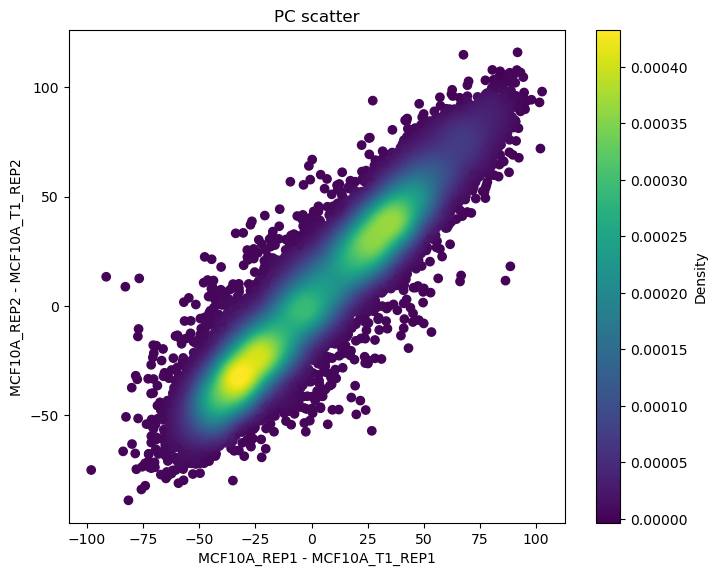

In [10]:
dff1 = df1[
    (df1["rep1"] == "hg38_001_MCF10A_WT_REP1")
    & (df1["rep2"] == "hg38_003_MCF10A_T1_REP1")
]
dff2 = df1[
    (df1["rep1"] == "hg38_002_MCF10A_WT_REP2")
    & (df1["rep2"] == "hg38_004_MCF10A_T1_REP2")
]

fig, ax = plt.subplots(1, 1, figsize=(8, 6.4))

density_scatter(
    dff1["pca_delta"].to_numpy(), dff2["pca_delta"].to_numpy(), ax=ax, fig=fig
)

ax.set(
    title="PC scatter",
    xlabel="MCF10A_REP1 - MCF10A_T1_REP1",
    ylabel="MCF10A_REP2 - MCF10A_T1_REP2",
)

fig.savefig("/tmp/pca_scatter_wt_t1.png", dpi=300)

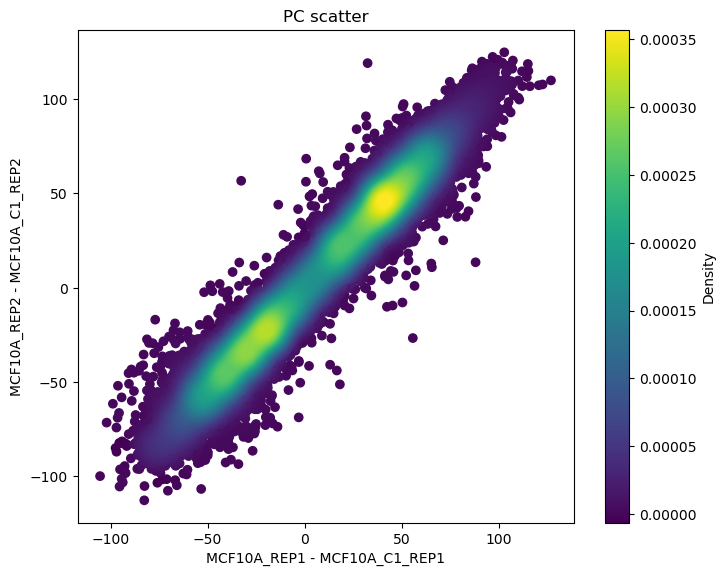

In [11]:
dff1 = df1[
    (df1["rep1"] == "hg38_001_MCF10A_WT_REP1")
    & (df1["rep2"] == "hg38_005_MCF10A_C1_REP1")
]
dff2 = df1[
    (df1["rep1"] == "hg38_002_MCF10A_WT_REP2")
    & (df1["rep2"] == "hg38_006_MCF10A_C1_REP2")
]

fig, ax = plt.subplots(1, 1, figsize=(8, 6.4))

density_scatter(
    dff1["pca_delta"].to_numpy(), dff2["pca_delta"].to_numpy(), ax=ax, fig=fig
)

ax.set(
    title="PC scatter",
    xlabel="MCF10A_REP1 - MCF10A_C1_REP1",
    ylabel="MCF10A_REP2 - MCF10A_C1_REP2",
)

fig.savefig("/tmp/pca_scatter_wt_c1.png", dpi=300)

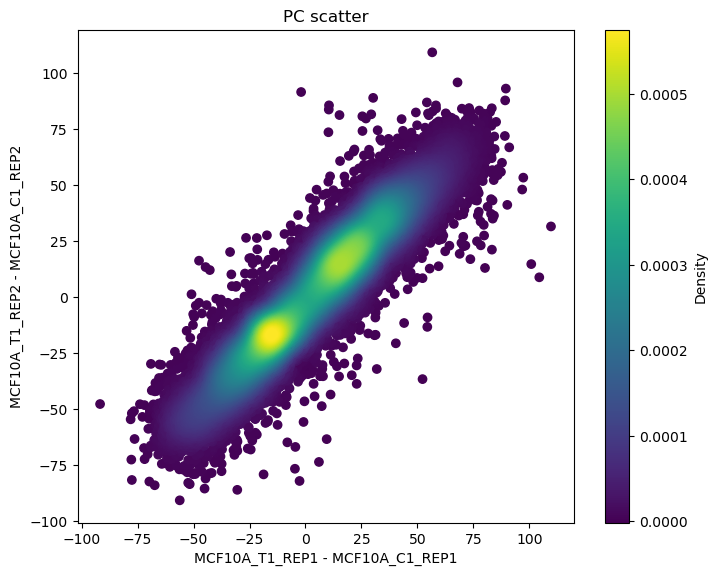

In [12]:
dff1 = df1[
    (df1["rep1"] == "hg38_003_MCF10A_T1_REP1")
    & (df1["rep2"] == "hg38_005_MCF10A_C1_REP1")
]
dff2 = df1[
    (df1["rep1"] == "hg38_004_MCF10A_T1_REP2")
    & (df1["rep2"] == "hg38_006_MCF10A_C1_REP2")
]

fig, ax = plt.subplots(1, 1, figsize=(8, 6.4))

density_scatter(
    dff1["pca_delta"].to_numpy(), dff2["pca_delta"].to_numpy(), ax=ax, fig=fig
)

ax.set(
    title="PC scatter",
    xlabel="MCF10A_T1_REP1 - MCF10A_C1_REP1",
    ylabel="MCF10A_T1_REP2 - MCF10A_C1_REP2",
)

fig.savefig("/tmp/pca_scatter_t1_c1.png", dpi=300)